# Toy Machine Learning Pipeline: exploratory data analysis

*Last update: 11/03/2021*

The present notebook is a companion analysis of the current state of the pipeline. Summarizing the data cleaning, feature generation, and how the model was fit.

The machine learning goal in the project as described in the [README](https://github.com/shreyashankar/toy-ml-pipeline#ML-task-description-and-evaluation-procedure) is:

 > *We train* ***a model to predict whether a passenger in a NYC taxicab ride will give the driver a large tip***. *This is a binary classification task. A large tip is arbitrarily defined as greater than 20% of the total fare (before tip).* ***To evaluate the model or measure the efficacy of the model, we measure the F1 score.***

In the following notebooks there will be new feature exploration and model alternatives.

Therefore, the target variable in the dataset is discretize into two categories from `tip_amount`.

**How to run this notebook?**

```bash
# build the image
docker build -t toy-ml-pipeline .

# start the container
docker run -d -p 8888:8888 --env-file=./.env --mount type=bind,src="$PWD"/eda,dst=/app/eda toy-ml-pipeline
```

In [35]:
# import modules
from utils.io import list_files, load_output_df
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Load the data

How can we access to the data in buckets?

In this section we will used the function written in the module `utils.io` to access the data stored in s3 buckets.

Firstly, we can use the function `utils.io.list_files()` to explore into each component's buckets.

In [36]:
list_files('dev')

['toy-applied-ml-pipeline/dev/',
 'toy-applied-ml-pipeline/dev/clean',
 'toy-applied-ml-pipeline/dev/clean_online',
 'toy-applied-ml-pipeline/dev/features',
 'toy-applied-ml-pipeline/dev/features_online',
 'toy-applied-ml-pipeline/dev/inference',
 'toy-applied-ml-pipeline/dev/predictions_online',
 'toy-applied-ml-pipeline/dev/test',
 'toy-applied-ml-pipeline/dev/test_online',
 'toy-applied-ml-pipeline/dev/train_online',
 'toy-applied-ml-pipeline/dev/training']

In [37]:
list_files('dev/clean')

['toy-applied-ml-pipeline/dev/clean/',
 'toy-applied-ml-pipeline/dev/clean/2020_01',
 'toy-applied-ml-pipeline/dev/clean/2020_02',
 'toy-applied-ml-pipeline/dev/clean/2020_03',
 'toy-applied-ml-pipeline/dev/clean/2020_04',
 'toy-applied-ml-pipeline/dev/clean/2020_05',
 'toy-applied-ml-pipeline/dev/clean/2020_06',
 'toy-applied-ml-pipeline/dev/clean/2020_07',
 'toy-applied-ml-pipeline/dev/clean/2020_08',
 'toy-applied-ml-pipeline/dev/clean/2020_09',
 'toy-applied-ml-pipeline/dev/clean/2020_10',
 'toy-applied-ml-pipeline/dev/clean/2020_11',
 'toy-applied-ml-pipeline/dev/clean/2020_12',
 'toy-applied-ml-pipeline/dev/clean/20210302-163649.pq',
 'toy-applied-ml-pipeline/dev/clean/test.pq']

We will explore the data using the version `2020_01`.

Now we can use the function `utils.io.load_data_df()`:

In [38]:
clean01 = load_output_df('clean', version='2020_01')

Understand the computation steps involved to clean the data performed by `etl/cleaning.py`.

The data cleaning process only consist in "drops rows outside the time range or with $0-valued fares)".

## 2. Exploratory Data Analysis

### 2.1 Data structure

The *codebook* for this dataset is detailed in the [README.md](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

In [39]:
clean01.shape

(5977829, 18)

In [40]:
clean01.head(n=2)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,2.0,2020-01-01 00:30:07,2020-01-02 00:28:18,1.0,0.35,1.0,N,166,166,1.0,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0
1,2.0,2020-01-01 00:53:40,2020-01-02 00:18:40,6.0,3.96,1.0,N,246,261,1.0,17.5,0.5,0.5,4.26,0.0,0.3,27.51,2.5


The trip duration can derive from the datetime columns `tpep_pickup_datetime` and `tpep_dropoff_datetime`.

In [41]:
clean01['trip_duration_min'] = pd.to_timedelta(
                                    clean01.tpep_dropoff_datetime - clean01.tpep_pickup_datetime
                               ).astype('timedelta64[m]').astype(int)

Trip duration has an implicit contrain it has to be `>=0`. There is a trip with negative duration?

In [111]:
clean01[~(clean01.trip_duration_min >= 0)]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,trip_duration_min,amount_over_tripduration


Apparently there are 3 trips that were cancelled instantly and 1 with some record mistake in the datetimes (*you can travel to the past, at least now*).

We will simply remove the 4 records from `clean01`.

In [120]:
clean01 = clean01[clean01.trip_duration_min > 0]

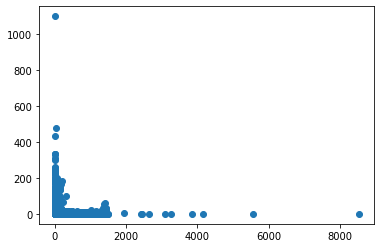

In [112]:
plt.scatter(clean01.trip_duration_min, clean01.tip_amount)

There are trips with a duration beyond a day (i.e. 1440 minutes). We can inspect if the `total_amount` of this trips are coherent with the `trip_duration_min`.

In [68]:
clean01[clean01.trip_duration_min >= 1440].\
             sort_values('trip_duration_min', ascending=False)\
             [['trip_duration_min', 'total_amount']]

,trip_duration_min,total_amount
3868568,8525,4268.30
4521153,5549,8.80
774455,4168,3.80
2115280,3840,3.30
4874732,3267,1722.30
4706093,3096,3.80
5316676,2656,3.80
302764,2458,1242.30
478840,2433,4.30
3780717,1946,26.75


It doesn't make sense that a taxi agree in doing a large trip and charge less than $100.

Using this logic we can calculate the ratio `total_amount / trip_duration_min` and filter every row with lower value (*i.e. less than 0.01 or 1 cent per travel minute*).

In [118]:
clean01['amount_over_tripduration'] = clean01['total_amount'] / clean01['trip_duration_min']

In [119]:
clean01[clean01.amount_over_tripduration < .01][['trip_distance', 'trip_duration_min', 'total_amount', 'amount_over_tripduration']]

,trip_distance,trip_duration_min,total_amount,amount_over_tripduration
0,0.35,1438,4.80,0.003338
2,1.03,1438,12.88,0.008957
5,1.08,1437,7.80,0.005428
10,0.50,1436,8.30,0.005780
15,1.92,1416,13.53,0.009555
...,...,...,...,...
5681168,1.34,1395,10.80,0.007742
5681213,1.80,1429,12.30,0.008607
5761259,0.00,172,0.31,0.001802
5798215,1.60,93,0.31,0.003333


There is a visual way to inspect these?

In [117]:
clean01[clean01.amount_over_tripduration == np.Inf]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,trip_duration_min,amount_over_tripduration
797,1.0,2020-01-01 23:59:17,2020-01-02 00:00:13,1.0,0.10,1.0,N,41,41,2.0,3.00,0.50,0.5,0.00,0.00,0.3,4.30,0.0,0,inf
1187,2.0,2020-01-02 00:03:53,2020-01-02 00:04:37,1.0,0.00,1.0,N,7,7,2.0,2.50,0.50,0.5,0.00,0.00,0.3,3.80,0.0,0,inf
1259,2.0,2020-01-02 00:56:14,2020-01-02 00:56:30,2.0,0.00,2.0,N,236,236,1.0,52.00,0.00,0.5,12.00,6.12,0.3,70.92,0.0,0,inf
1302,2.0,2020-01-02 00:54:40,2020-01-02 00:55:37,1.0,0.34,1.0,N,90,186,2.0,3.00,0.50,0.5,0.00,0.00,0.3,6.80,2.5,0,inf
1369,2.0,2020-01-02 00:27:23,2020-01-02 00:28:08,2.0,0.19,1.0,N,49,49,2.0,3.00,0.50,0.5,0.00,0.00,0.3,4.30,0.0,0,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5976899,NaN,2020-01-30 15:41:00,2020-01-30 15:41:00,NaN,0.07,NaN,None,65,65,NaN,30.55,2.75,0.5,0.00,0.00,0.3,34.10,0.0,0,inf
5976900,NaN,2020-01-30 15:13:00,2020-01-30 15:13:00,NaN,0.02,NaN,None,112,112,NaN,16.23,2.75,0.5,0.00,0.00,0.3,19.78,0.0,0,inf
5976957,NaN,2020-01-30 16:25:00,2020-01-30 16:25:00,NaN,0.00,NaN,None,264,264,NaN,25.00,0.00,0.5,5.16,0.00,0.3,32.91,0.0,0,inf
5977208,NaN,2020-01-30 18:03:00,2020-01-30 18:03:00,NaN,0.03,NaN,None,263,262,NaN,35.29,2.75,0.5,0.00,0.00,0.3,38.84,0.0,0,inf


ValueError: supplied range of [0.000859375, inf] is not finite

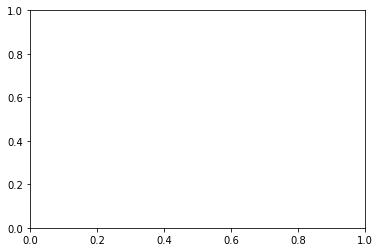

In [115]:
plt.hist(clean01.amount_over_tripduration,
        bins=10, alpha=.5,
        histtype='stepfilled', color='firebrick',
        edgecolor='none')

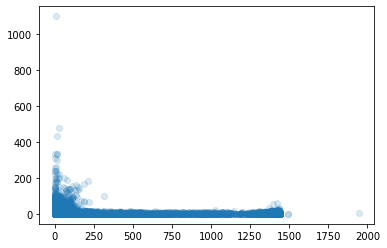

In [48]:
plt.scatter(clean01_lt2k.trip_duration_min, 
            clean01_lt2k.tip_amount,
            alpha=.16)

In [49]:
clean01_lt2k

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,trip_duration_min
0,2.0,2020-01-01 00:30:07,2020-01-02 00:28:18,1.0,0.35,1.0,N,166,166,1.0,3.50,0.50,0.5,0.00,0.00,0.3,4.80,0.0,1438
1,2.0,2020-01-01 00:53:40,2020-01-02 00:18:40,6.0,3.96,1.0,N,246,261,1.0,17.50,0.50,0.5,4.26,0.00,0.3,27.51,2.5,1405
2,2.0,2020-01-01 00:38:39,2020-01-02 00:37:22,2.0,1.03,1.0,N,114,79,1.0,6.50,0.50,0.5,2.58,0.00,0.3,12.88,2.5,1438
3,2.0,2020-01-01 00:13:41,2020-01-02 00:11:35,1.0,4.35,1.0,N,263,113,2.0,15.00,0.50,0.5,0.00,0.00,0.3,18.80,2.5,1437
4,2.0,2020-01-01 00:28:27,2020-01-02 00:26:48,3.0,1.67,1.0,N,161,142,2.0,13.50,0.50,0.5,0.00,0.00,0.3,17.30,2.5,1438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977824,NaN,2020-01-29 13:29:00,2020-01-29 14:03:00,NaN,11.24,NaN,None,144,22,NaN,31.57,2.75,0.5,0.00,6.12,0.3,41.24,0.0,34
5977825,NaN,2020-01-29 13:40:54,2020-01-29 13:53:11,NaN,1.43,NaN,None,205,122,NaN,28.58,2.75,0.0,0.00,0.00,0.3,31.63,0.0,12
5977826,NaN,2020-01-29 13:58:00,2020-01-29 15:00:00,NaN,14.47,NaN,None,75,61,NaN,36.21,2.75,0.5,0.00,0.00,0.3,39.76,0.0,62
5977827,NaN,2020-01-29 13:29:00,2020-01-29 13:48:00,NaN,7.13,NaN,None,79,129,NaN,25.16,2.75,0.5,0.00,6.12,0.3,34.83,0.0,19


### 2.2 Feature engineering

In this section, we explore and reproduce the featured generated by `etl/featuregen.py`.

## 3. Model development

Train the current model...

### 3.1 Fit the current model

### 3.2 How the model wrapper works?